# EDA, Preprocessing, Feature Engineering

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import json
import matplotlib.pyplot as plt


import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

pd.set_option('display.max_columns', None)

Import columns

In [2]:
with open('../params/cols.txt') as file:
    cols = [line.rstrip() for line in file]
len(cols)

42

In [3]:
col_types = {"age": "continuous",
"class of worker": "nominal",
"detailed industry recode": "nominal",
"detailed occupation recode": "nominal",
"education": "nominal",
"wage per hour": "continuous",
"enroll in edu inst last wk": "nominal",
"marital stat": "nominal",
"major industry code": "nominal",
"major occupation code": "nominal",
"race": "nominal",
"hispanic origin": "nominal",
"sex": "nominal",
"member of a labor union": "nominal",
"reason for unemployment": "nominal",
"full or part time employment stat": "nominal",
"capital gains": "continuous",
"capital losses": "continuous",
"dividends from stocks": "continuous",
"tax filer stat": "nominal",
"region of previous residence": "nominal",
"state of previous residence": "nominal",
"detailed household and family stat": "nominal",
"detailed household summary in household": "nominal",
"migration code-change in msa": "nominal",
"migration code-change in reg": "nominal",
"migration code-move within reg": "nominal",
"live in this house 1 year ago": "nominal",
"migration prev res in sunbelt": "nominal",
"num persons worked for employer": "continuous",
"family members under 18": "nominal",
"country of birth father": "nominal",
"country of birth mother": "nominal",
"country of birth self": "nominal",
"citizenship": "nominal",
"own business or self employed": "nominal",
"fill inc questionnaire for veteran's admin": "nominal",
"veterans benefits": "nominal",
"weeks worked in year": "continuous",
"year": "nominal"}

Import datasets

In [4]:
# load data
train = pd.read_csv('../data/raw/census_income_learn.csv', names=cols, na_values=' ?')
test = pd.read_csv('../data/raw/census_income_test.csv', names=cols, na_values=' ?')

In [5]:
# compare shape
print(f"train shape: {train.shape}")
print(f"test shape: {test.shape}")

train shape: (199523, 42)
test shape: (99762, 42)


In [6]:
train['income'].value_counts()

 - 50000.    187141
 50000+.      12382
Name: income, dtype: int64

In [7]:
test['income'].value_counts()

 - 50000.    93576
 50000+.      6186
Name: income, dtype: int64

In [8]:
def convert_dtypes(df, mapping):
# Convert object dtype to category
    for k in mapping:
        if mapping[k] == "continuous":
            df[k] = df[k].astype('int64')
        elif mapping[k] == "nominal":
            df[k] = df[k].astype('category')
    return df

In [9]:
train = convert_dtypes(train, mapping=col_types)
test = convert_dtypes(test, mapping=col_types)

## Data Cleansing
1. Remove `instance weight` column
2. Deduplicate
3. Convert income column to binary
4. Deal with missing values

#### 1. Remove `instance weight` column

The metadata file reads:
```
| The instance weight indicates the number of people in the population
| that each record represents due to stratified sampling.
| To do real analysis and derive conclusions, this field must be used.
| This attribute should *not* be used in the classifiers, so it is
| set to "ignore" in this file.
```
Therefore, this should be excluded from the dataset.

In [10]:
# remove `instance weight` column
train = train.drop(columns=['instance weight'])
test = test.drop(columns=['instance weight'])
# compare shape
print(f"train shape: {train.shape}")
print(f"test shape: {test.shape}")

train shape: (199523, 41)
test shape: (99762, 41)


### 2. Deduplicate rows

According to the metadata file, there are duplicate rows. These should be removed.

In [11]:
# find where there are duplicates (excluding 'income' column), check it matches expected value from metadata file
train_dupes = train.loc[:, train.columns != 'income'].duplicated()
test_dupes = test.loc[:, test.columns != 'income'].duplicated()
print(f"number of duplicates: {train_dupes.sum()}")
print(f"number of duplicates: {test_dupes.sum()}")

number of duplicates: 46716
number of duplicates: 20936


In [12]:
# remove duplicates
train = train[~train_dupes]
test = test[~test_dupes]
# compare shape
print(f"train shape: {train.shape}")
print(f"test shape: {test.shape}")

train shape: (152807, 41)
test shape: (78826, 41)


#### 3. Convert income to binary

In [13]:
# convert income to binary
train['income']=train['income'].map({' - 50000.': '< $50k', ' 50000+.': '> $50k'})
test['income']=test['income'].map({' - 50000.': '< $50k', ' 50000+.': '> $50k'})
train.head(5)

,age,class of worker,detailed industry recode,detailed occupation recode,education,wage per hour,enroll in edu inst last wk,marital stat,major industry code,major occupation code,race,hispanic origin,sex,member of a labor union,reason for unemployment,full or part time employment stat,capital gains,capital losses,dividends from stocks,tax filer stat,region of previous residence,state of previous residence,detailed household and family stat,detailed household summary in household,migration code-change in msa,migration code-change in reg,migration code-move within reg,live in this house 1 year ago,migration prev res in sunbelt,num persons worked for employer,family members under 18,country of birth father,country of birth mother,country of birth self,citizenship,own business or self employed,fill inc questionnaire for veteran's admin,veterans benefits,weeks worked in year,year,income
0,73,Not in universe,0,0,High school graduate,0,Not in universe,Widowed,Not in universe or children,Not in universe,White,All other,Female,Not in universe,Not in universe,Not in labor force,0,0,0,Nonfiler,Not in universe,Not in universe,Other Rel 18+ ever marr not in subfamily,Other relative of householder,NaN,NaN,NaN,Not in universe under 1 year old,NaN,0,Not in universe,United-States,United-States,United-States,Native- Born in the United States,0,Not in universe,2,0,95,< $50k
1,58,Self-employed-not incorporated,4,34,Some college but no degree,0,Not in universe,Divorced,Construction,Precision production craft & repair,White,All other,Male,Not in universe,Not in universe,Children or Armed Forces,0,0,0,Head of household,South,Arkansas,Householder,Householder,MSA to MSA,Same county,Same county,No,Yes,1,Not in universe,United-States,United-States,United-States,Native- Born in the United States,0,Not in universe,2,52,94,< $50k
2,18,Not in universe,0,0,10th grade,0,High school,Never married,Not in universe or children,Not in universe,Asian or Pacific Islander,All other,Female,Not in universe,Not in universe,Not in labor force,0,0,0,Nonfiler,Not in universe,Not in universe,Child 18+ never marr Not in a subfamily,Child 18 or older,NaN,NaN,NaN,Not in universe under 1 year old,NaN,0,Not in universe,Vietnam,Vietnam,Vietnam,Foreign born- Not a citizen of U S,0,Not in universe,2,0,95,< $50k
3,9,Not in universe,0,0,Children,0,Not in universe,Never married,Not in universe or children,Not in universe,White,All other,Female,Not in universe,Not in universe,Children or Armed Forces,0,0,0,Nonfiler,Not in universe,Not in universe,Child <18 never marr not in subfamily,Child under 18 never married,Nonmover,Nonmover,Nonmover,Yes,Not in universe,0,Both parents present,United-States,United-States,United-States,Native- Born in the United States,0,Not in universe,0,0,94,< $50k
4,10,Not in universe,0,0,Children,0,Not in universe,Never married,Not in universe or children,Not in universe,White,All other,Female,Not in universe,Not in universe,Children or Armed Forces,0,0,0,Nonfiler,Not in universe,Not in universe,Child <18 never marr not in subfamily,Child under 18 never married,Nonmover,Nonmover,Nonmover,Yes,Not in universe,0,Both parents present,United-States,United-States,United-States,Native- Born in the United States,0,Not in universe,0,0,94,< $50k


In [14]:
continuous_cols = []
categorical_cols = []
for i in train.columns:
    print(f"COLUMN: {i}")
    print(train[i].dtype)
    if train[i].dtype == 'int64':
        continuous_cols.append(i)
        print("numeric")
        print(train[i].nunique())
    else:
        categorical_cols.append(i)
        print(train[i].nunique())
        print(train[i].value_counts()[:20])
    print()

COLUMN: age
int64
numeric
91

COLUMN: class of worker
category
9
 Private                           71723
 Not in universe                   54109
 Self-employed-not incorporated     8314
 Local government                   7720
 State government                   4220
 Self-employed-incorporated         3256
 Federal government                 2919
 Never worked                        383
 Without pay                         163
Name: class of worker, dtype: int64

COLUMN: detailed industry recode
category
52
0     54492
33    16890
43     8216
4      5935
42     4670
45     4466
29     4196
37     4022
41     3944
32     3582
35     3371
39     2932
34     2753
44     2533
2      2125
11     1759
50     1704
40     1650
47     1640
38     1625
Name: detailed industry recode, dtype: int64

COLUMN: detailed occupation recode
category
47
0     54492
2      8746
26     7867
19     5336
29     5070
36     4141
34     3986
10     3625
16     3405
23     3379
12     3334
33     3314
3      

### 4. Deal with missing values

In [15]:
# check total missing values
print(f"train missing values: {train.isna().sum().sum()}")
print(f"test missing values: {test.isna().sum().sum()}")

train missing values: 315821
test missing values: 163706


In [16]:
# check nas and proportions
isna_df = pd.DataFrame(
    {"train_nas": train.isna().sum(), 
    "test_nas": test.isna().sum(),
    "prop_train_na": (train.isna().sum().values ) / len(train) * 100,
    "prop_test_na": (test.isna().sum().values ) / len(test) * 100 
    }
    )
isna_df = isna_df[(isna_df['train_nas'] > 0) | (isna_df['test_nas'] > 0)]
isna_df

,train_nas,test_nas,prop_train_na,prop_test_na
state of previous residence,698,327,0.456785,0.414838
migration code-change in msa,74902,38842,49.017388,49.275620
migration code-change in reg,74902,38842,49.017388,49.275620
migration code-move within reg,74902,38842,49.017388,49.275620
migration prev res in sunbelt,74902,38842,49.017388,49.275620
country of birth father,6383,3307,4.177165,4.195316
country of birth mother,5810,2969,3.802182,3.766524
country of birth self,3322,1735,2.173984,2.201050


#### Missing values
Large proportions of missing values for migration related columns. Possibly chose not to disclose, so not missing at random (NMAR) n/a values.

Unreliable to impute if around 50% of data missing, will remove from dataset.

In [17]:
### Data cleaning ###
def distribution_impute(df, col):
    # Record distribution
    attribute_dist = df[col].value_counts(normalize=True)

    # Impute NaN
    nulls = df[col].isna()
    df.loc[nulls, col] = np.random.choice(attribute_dist.index, size=len(df[nulls]), p=attribute_dist.values)

In [18]:
isna_df_cols = list(isna_df.index)
# Impute Nan
for col in isna_df_cols:
    distribution_impute(train, col)
    distribution_impute(test, col)

In [19]:
# check total missing values
print(f"train missing values: {train.isna().sum().sum()}")
print(f"test missing values: {test.isna().sum().sum()}")

train missing values: 0
test missing values: 0


## EDA

In [20]:
numeric_cols = list(train.select_dtypes(['int64']).columns)
category_cols = list(train.select_dtypes(['category']).columns)

In [21]:
features = [
    "age", #likely useful
    "class of worker", #likely useful
    "education", #likely useful
    "marital stat", #likely useful
    "major industry code", #likely useful
    "major occupation code", #likely useful
    "race", #likely useful
    "sex", #likely useful
    "capital gains",
    "capital losses",
    "dividends from stocks",
    "country of birth self",
    "citizenship",
    "own business or self employed",
    "weeks worked in year",
    "wage per hour",
    "income"]

maybe_feats = [
    "detailed industry recode", #need to know more
    "detailed occupation recode", #need to know more
    "wage per hour", #likely too correlated
    "full or part time employment stat", #need to know more
    "tax filer stat",
    "detailed household and family stat", #unsure
    "detailed household summary in household", #unsure
    "migration code-change in msa",
    "migration code-change in reg",
    "migration code-move within reg",
    "live in this house 1 year ago",
    "migration prev res in sunbelt",
    "country of birth father",
    "country of birth mother",
]

likely_not = [
    "enroll in edu inst last wk", #Not in universe
    "hispanic origin", 
    "member of a labor union",
    "reason for unemployment",
    "region of previous residence",
    "state of previous residence", #Not in universe
    "num persons worked for employer",
    "family members under 18", #Not in universe
    "fill inc questionnaire for veteran's admin",
    "veterans benefits",
    "year"
    "income"
]

In [22]:
keep_features = [
    "age", #likely useful
    "class of worker", #likely useful
    "education", #likely useful
    "marital stat", #likely useful
    "major industry code", #likely useful
    "major occupation code", #likely useful
    "race", #likely useful
    "sex", #likely useful
    "capital gains",
    "capital losses",
    "dividends from stocks",
    "country of birth self",
    "citizenship",
    "own business or self employed",
    "weeks worked in year",
    "wage per hour",
    "income"]

In [23]:
train.head(2)

,age,class of worker,detailed industry recode,detailed occupation recode,education,wage per hour,enroll in edu inst last wk,marital stat,major industry code,major occupation code,race,hispanic origin,sex,member of a labor union,reason for unemployment,full or part time employment stat,capital gains,capital losses,dividends from stocks,tax filer stat,region of previous residence,state of previous residence,detailed household and family stat,detailed household summary in household,migration code-change in msa,migration code-change in reg,migration code-move within reg,live in this house 1 year ago,migration prev res in sunbelt,num persons worked for employer,family members under 18,country of birth father,country of birth mother,country of birth self,citizenship,own business or self employed,fill inc questionnaire for veteran's admin,veterans benefits,weeks worked in year,year,income
0,73,Not in universe,0,0,High school graduate,0,Not in universe,Widowed,Not in universe or children,Not in universe,White,All other,Female,Not in universe,Not in universe,Not in labor force,0,0,0,Nonfiler,Not in universe,Not in universe,Other Rel 18+ ever marr not in subfamily,Other relative of householder,Nonmover,Nonmover,Same county,Not in universe under 1 year old,Not in universe,0,Not in universe,United-States,United-States,United-States,Native- Born in the United States,0,Not in universe,2,0,95,< $50k
1,58,Self-employed-not incorporated,4,34,Some college but no degree,0,Not in universe,Divorced,Construction,Precision production craft & repair,White,All other,Male,Not in universe,Not in universe,Children or Armed Forces,0,0,0,Head of household,South,Arkansas,Householder,Householder,MSA to MSA,Same county,Same county,No,Yes,1,Not in universe,United-States,United-States,United-States,Native- Born in the United States,0,Not in universe,2,52,94,< $50k


#### Global stats

In [24]:
train.corr()

,age,wage per hour,capital gains,capital losses,dividends from stocks,num persons worked for employer,weeks worked in year
age,1.000000,-0.013268,0.041489,0.040473,0.106036,-0.074091,-0.022217
wage per hour,-0.013268,1.000000,-0.006834,0.002583,-0.011890,0.160500,0.163758
capital gains,0.041489,-0.006834,1.000000,-0.016652,0.129161,0.039666,0.067444
capital losses,0.040473,0.002583,-0.016652,1.000000,0.038537,0.057028,0.073104
dividends from stocks,0.106036,-0.011890,0.129161,0.038537,1.000000,-0.019234,-0.016405
num persons worked for employer,-0.074091,0.160500,0.039666,0.057028,-0.019234,1.000000,0.673209
weeks worked in year,-0.022217,0.163758,0.067444,0.073104,-0.016405,0.673209,1.000000


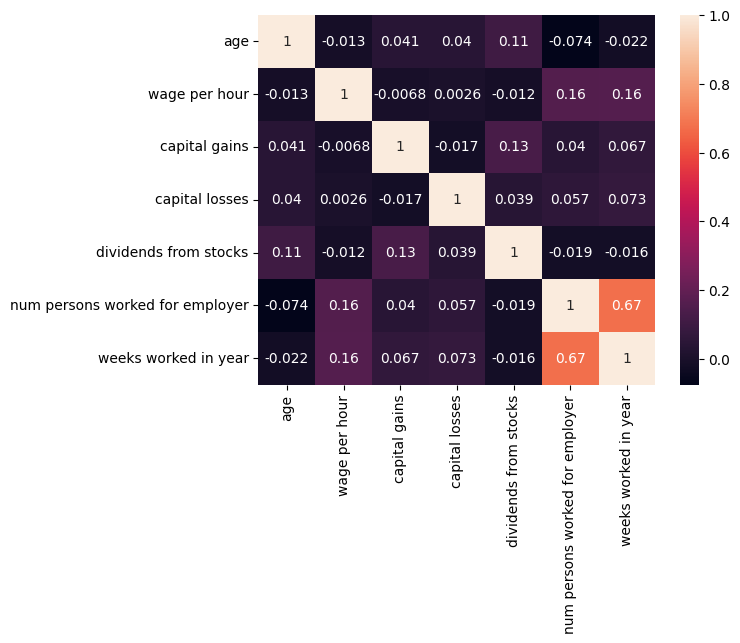

In [25]:
sns.heatmap(train.corr(), annot=True);

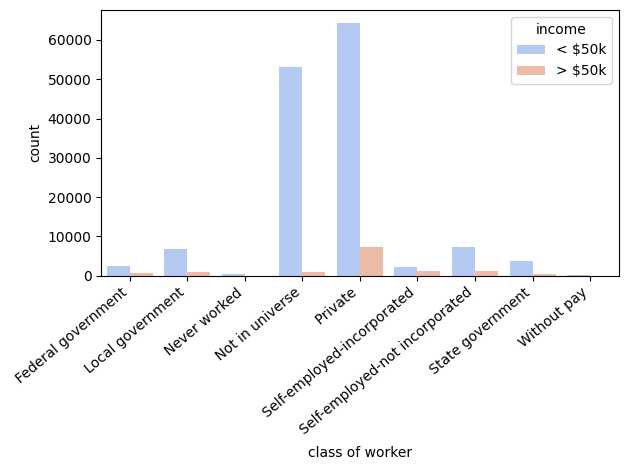

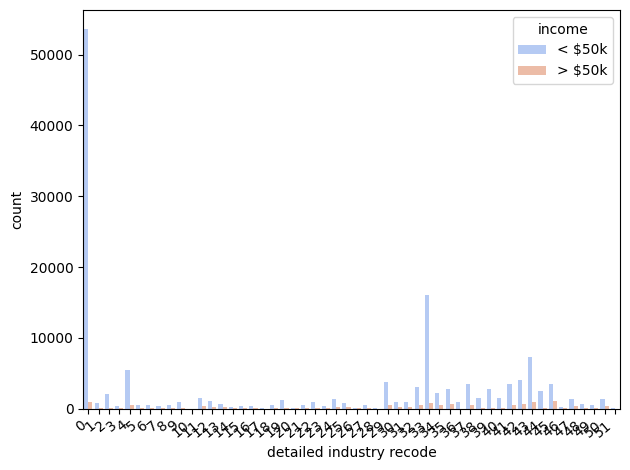

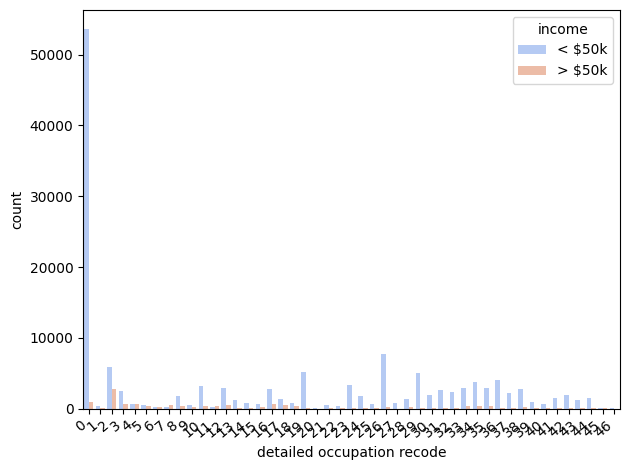

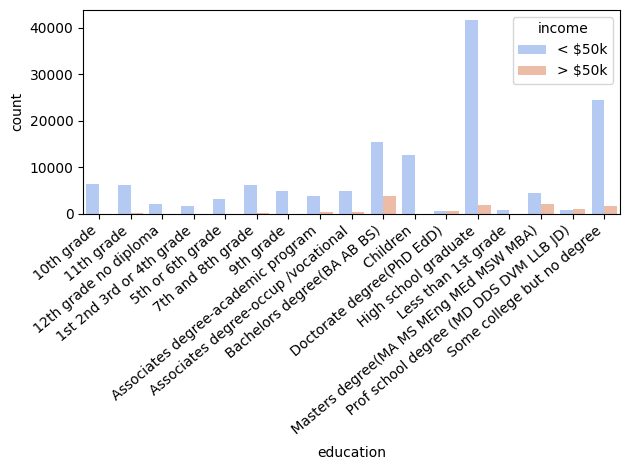

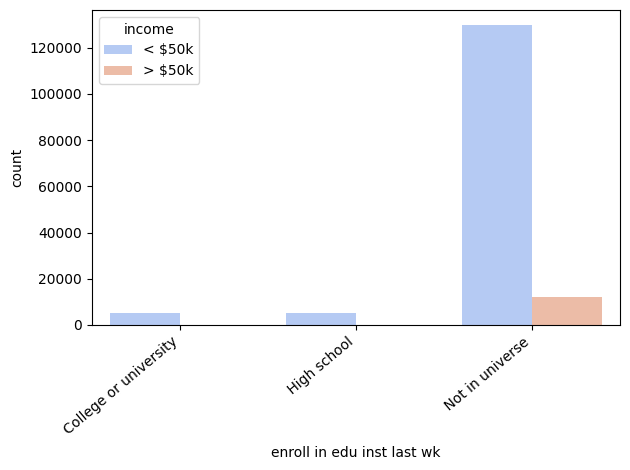

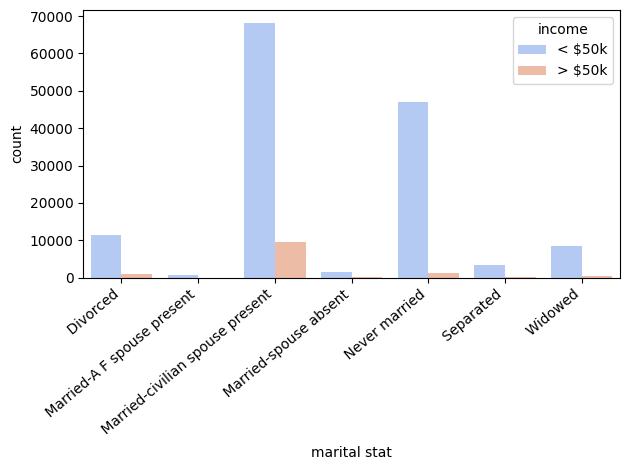

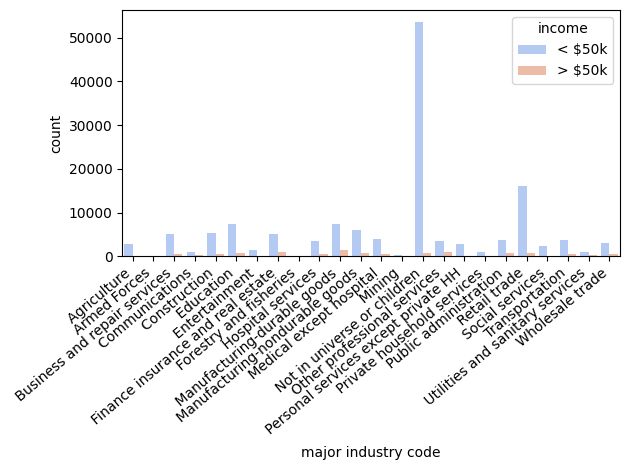

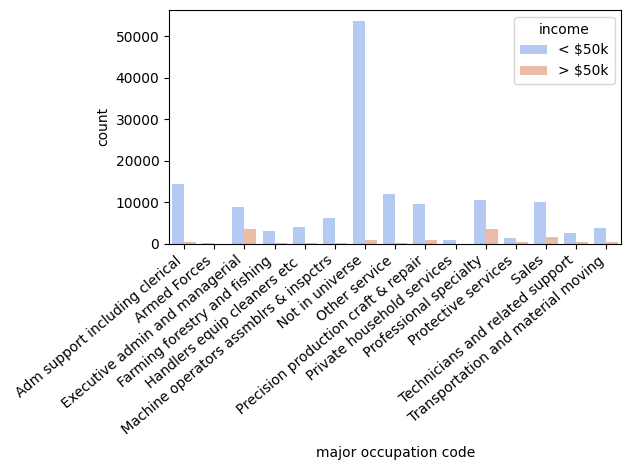

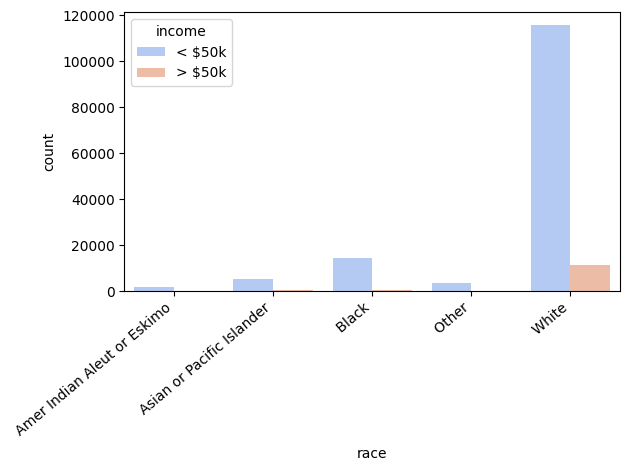

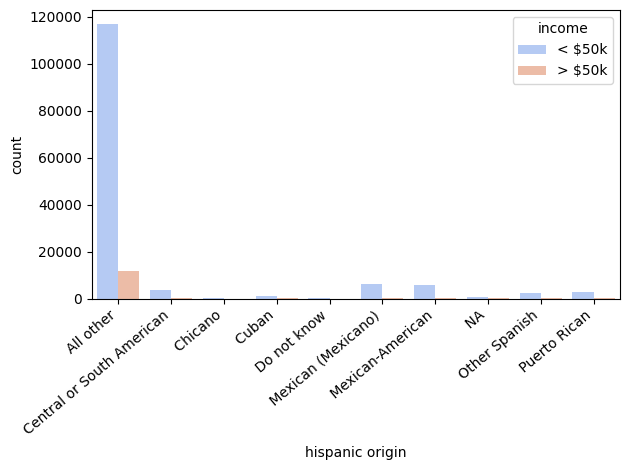

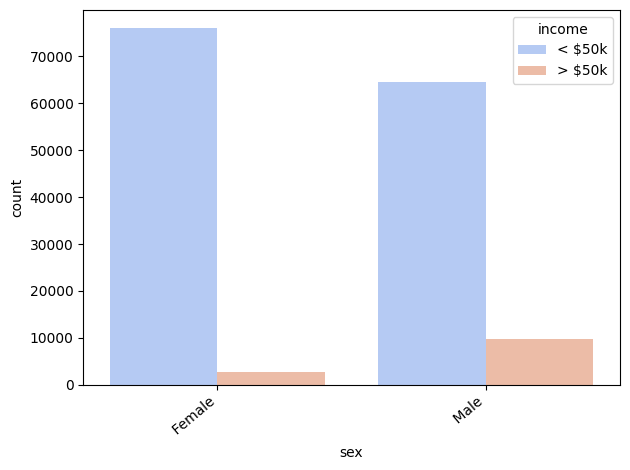

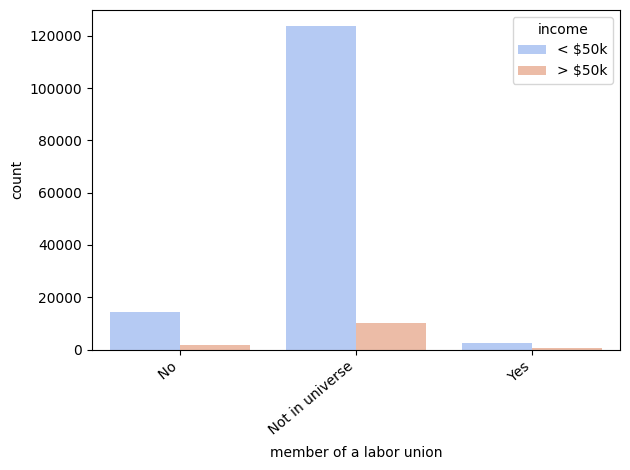

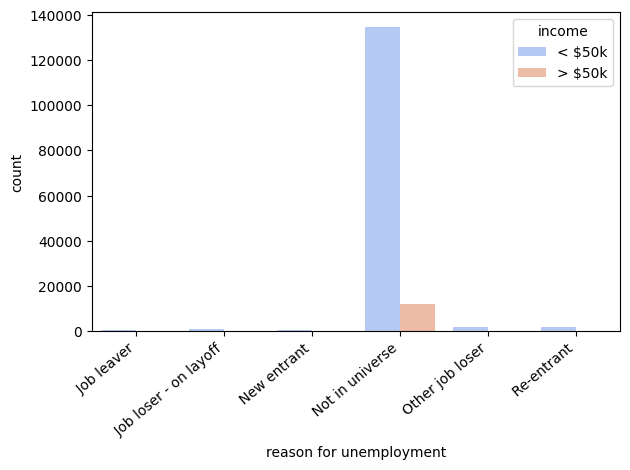

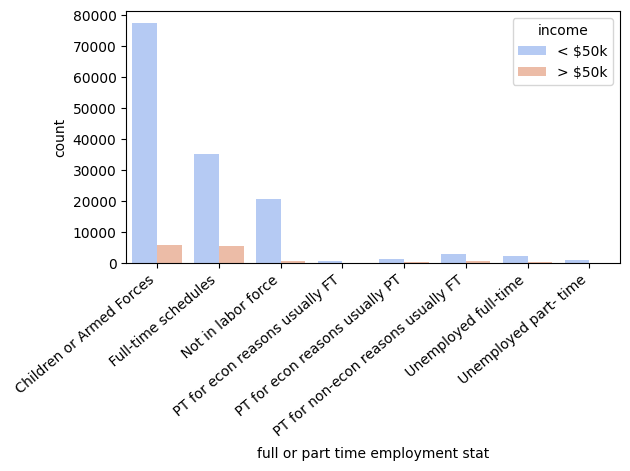

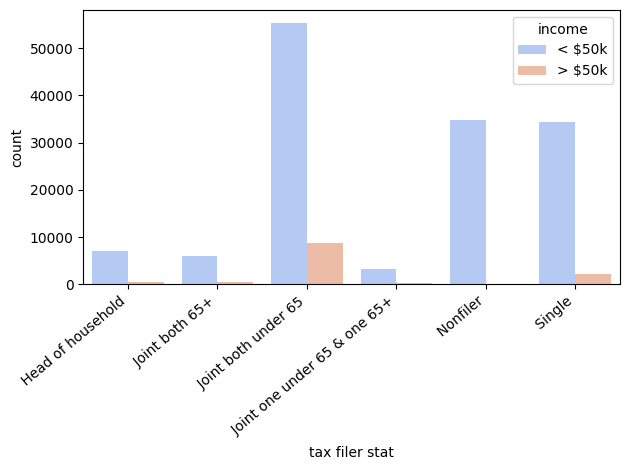

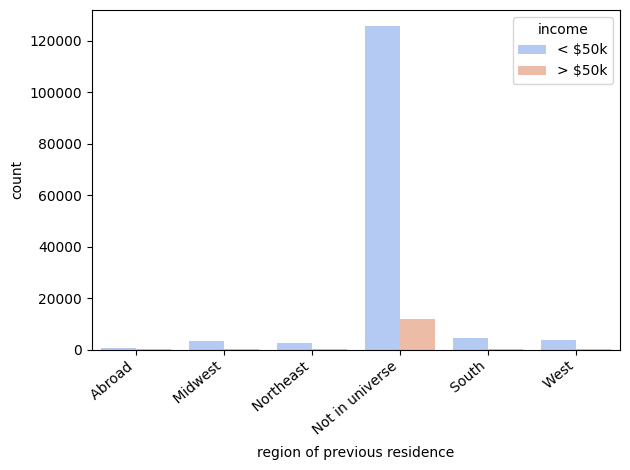

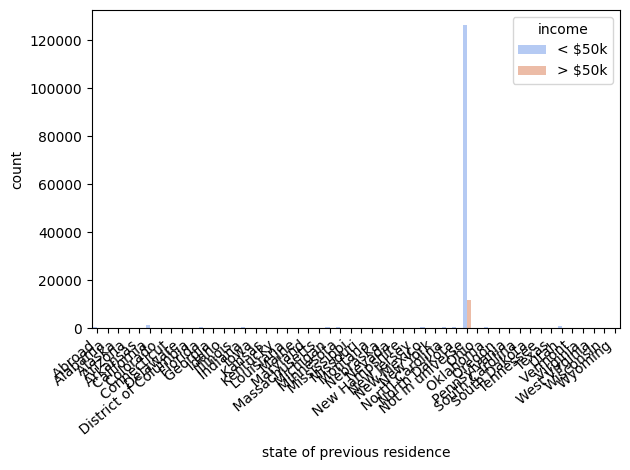

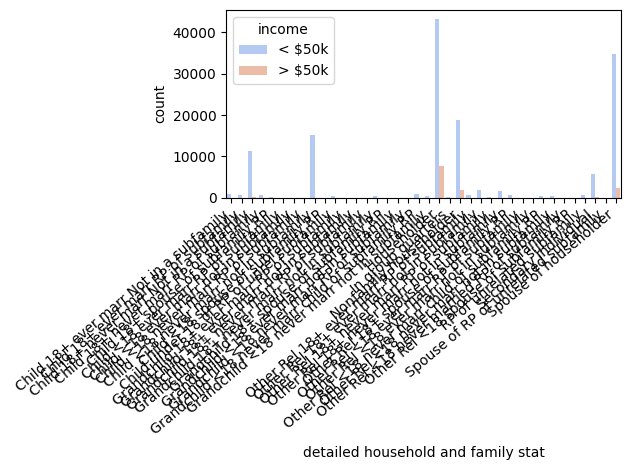

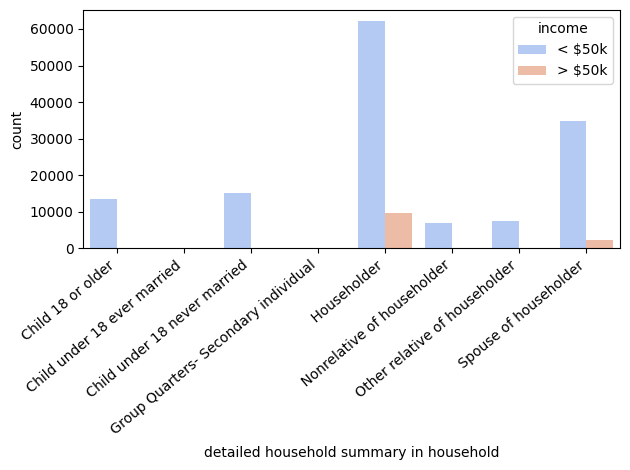

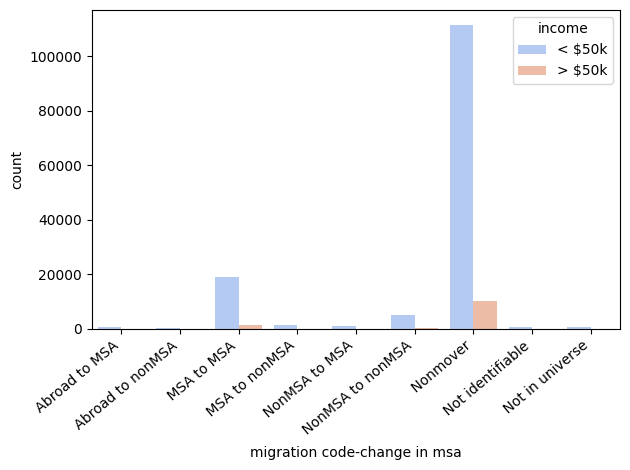

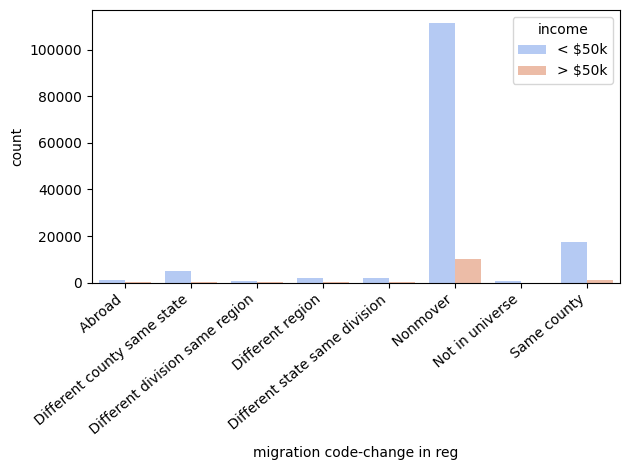

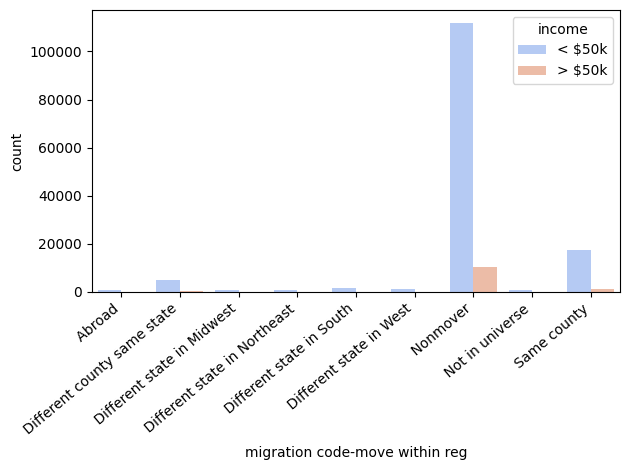

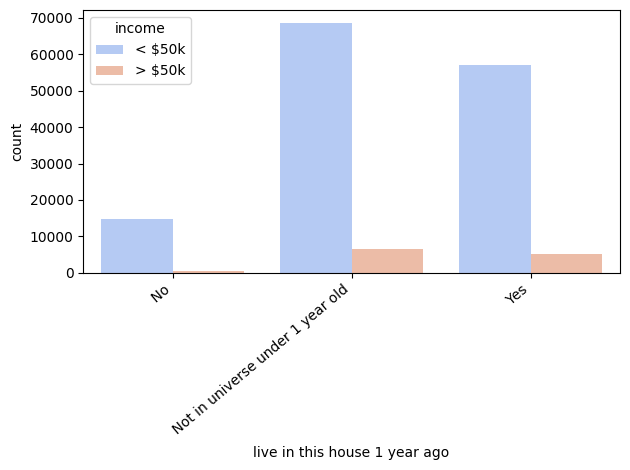

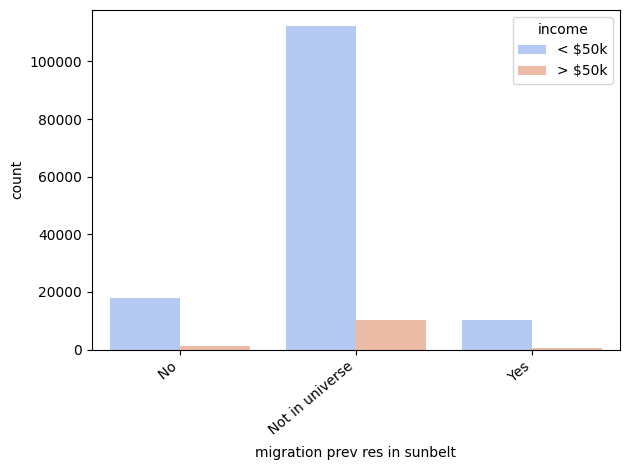

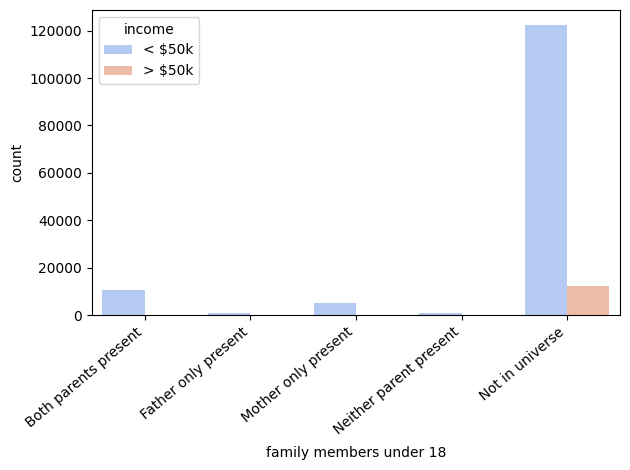

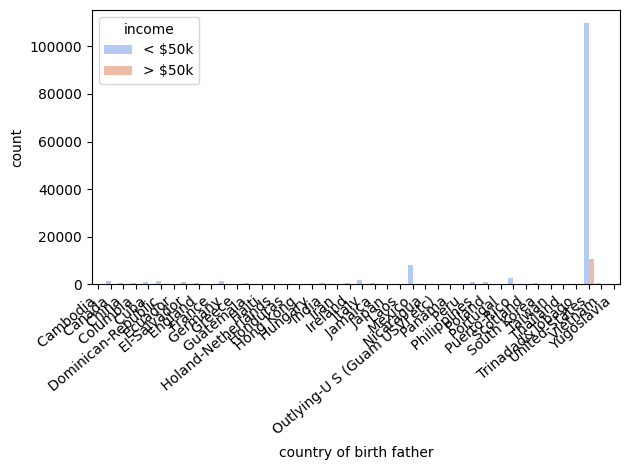

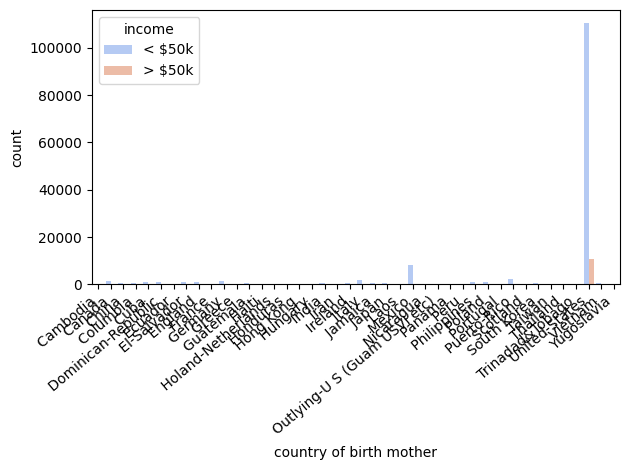

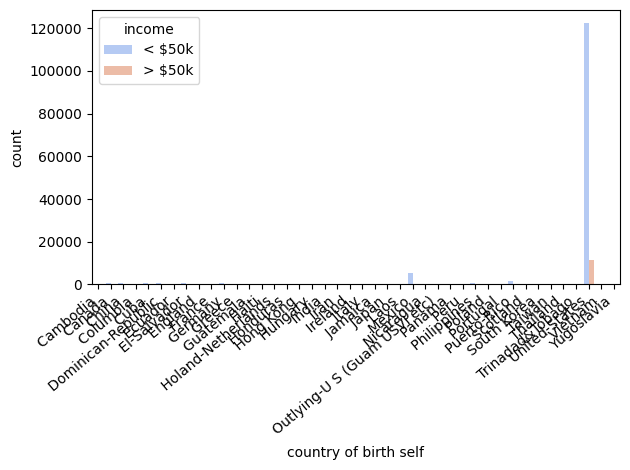

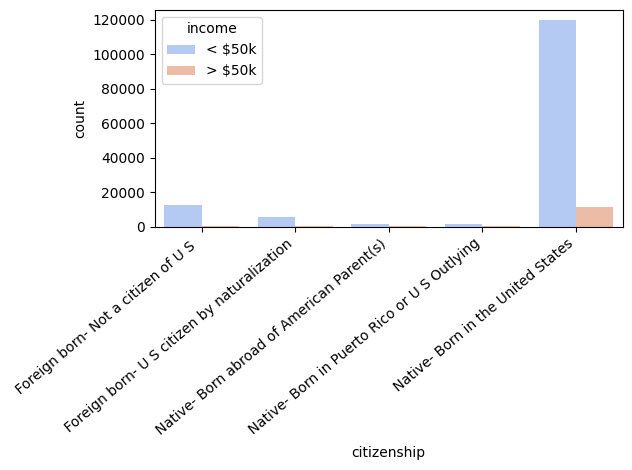

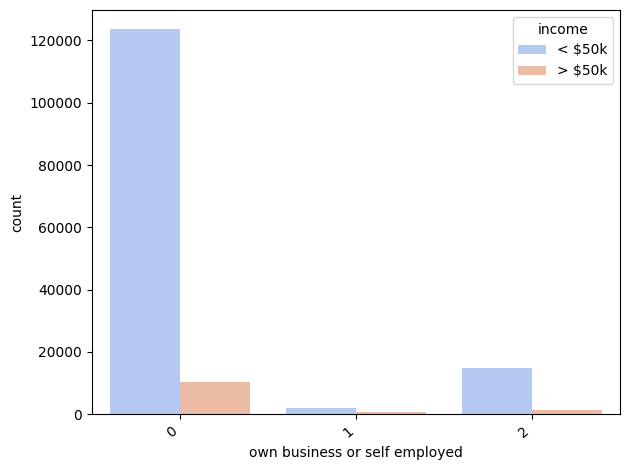

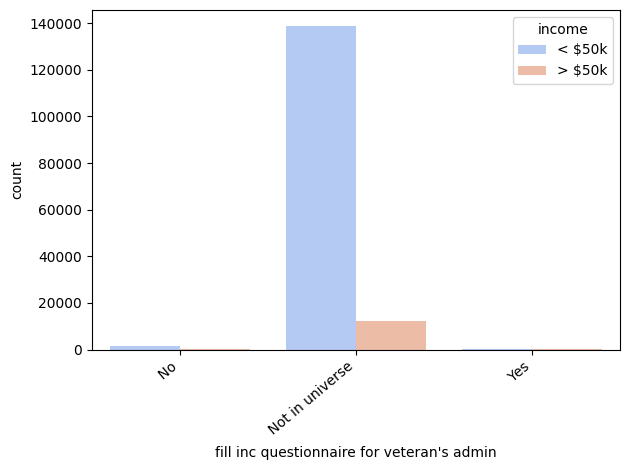

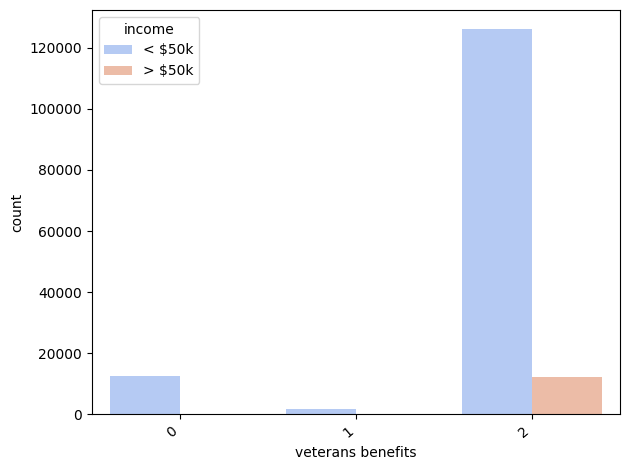

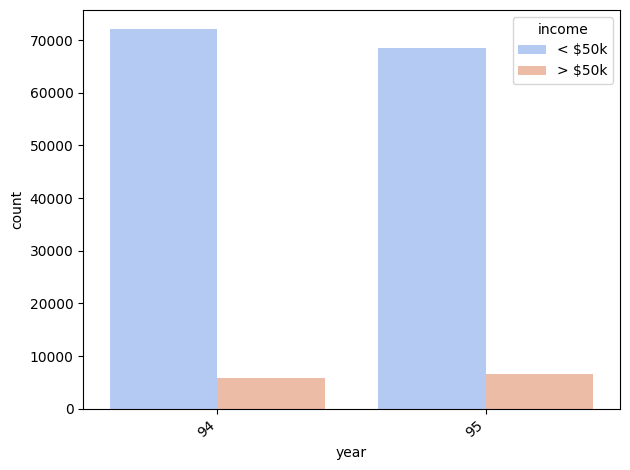

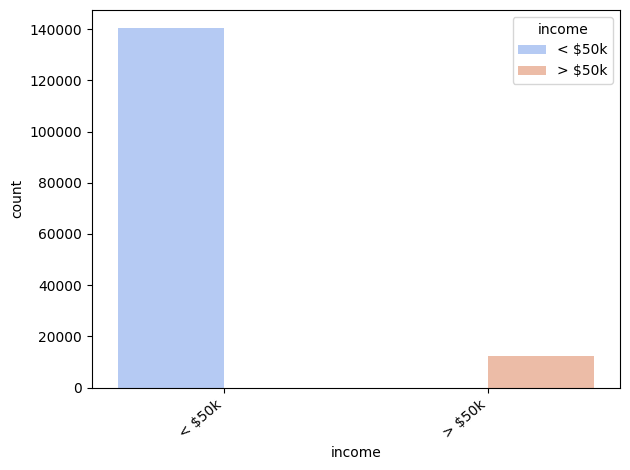

In [26]:
for i in categorical_cols:
    if i in train.columns:
        ax = sns.countplot(train, x=i, hue='income', palette='coolwarm')
        ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")
        plt.tight_layout()
        plt.show()

#### continuous variables

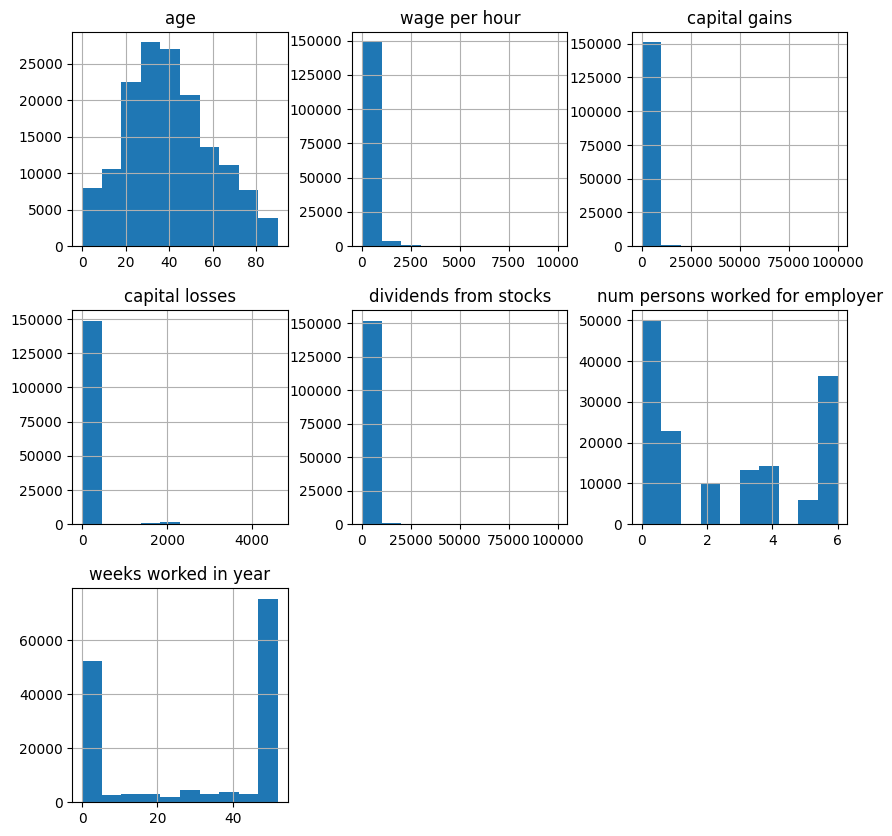

In [27]:
train.hist(figsize=(10,10), layout=(3,3), sharex=False);

To do:
- categorical
    - harmonise education categories
    - harmonise marriage stat
    - remove country of birth
- continuous 
    - unskew data

#### Feature engineering

In [28]:
# convert income to binary
train['income']=train['income'].map({'< $50k': 0, '> $50k': 1})
test['income']=test['income'].map({'< $50k': 0, '> $50k': 1})

In [29]:
# harmonise 'education' category
train['education'].replace([' Children', ' Less than 1st grade', ' 1st 2nd 3rd or 4th grade', ' 5th or 6th grade', ' 7th and 8th grade', ' 9th grade', ' 10th grade', ' 11th grade', ' 12th grade no diploma'], 'School', inplace=True)
train['education'].replace(' High school graduate', "High School", inplace=True)
train['education'].replace([' Some college but no degree', ' Associates degree-occup /vocational', ' Associates degree-academic program'], "Higher", inplace=True)
train['education'].replace(" Bachelors degree(BA AB BS)", "Undergraduate", inplace=True)
train['education'].replace(" Masters degree(MA MS MEng MEd MSW MBA)", "Graduate", inplace=True)
train['education'].replace(' Doctorate degree(PhD EdD)', "Doctorate", inplace=True)
train['education'].replace(" Prof school degree (MD DDS DVM LLB JD)", "PostDoctorate", inplace=True);

In [30]:
# harmonise 'marital stat' category
train['marital stat'].replace([' Married-spouse absent', ' Married-A F spouse present', ' Married-civilian spouse present'], 'Married', inplace=True)

In [31]:
# harmonise 'citizen stat' category
train['citizenship'].replace([' Native- Born abroad of American Parent(s)', ' Native- Born in Puerto Rico or U S Outlying', ' Native- Born in the United States'], 'US Native', inplace=True)
train['citizenship'].replace([' Foreign born- Not a citizen of U S ', ' Foreign born- U S citizen by naturalization'], 'Non-US Native', inplace=True)

In [32]:
#drop country of birth
train = train.drop(columns=['country of birth self'])

In [33]:
train.head()

,age,class of worker,detailed industry recode,detailed occupation recode,education,wage per hour,enroll in edu inst last wk,marital stat,major industry code,major occupation code,race,hispanic origin,sex,member of a labor union,reason for unemployment,full or part time employment stat,capital gains,capital losses,dividends from stocks,tax filer stat,region of previous residence,state of previous residence,detailed household and family stat,detailed household summary in household,migration code-change in msa,migration code-change in reg,migration code-move within reg,live in this house 1 year ago,migration prev res in sunbelt,num persons worked for employer,family members under 18,country of birth father,country of birth mother,citizenship,own business or self employed,fill inc questionnaire for veteran's admin,veterans benefits,weeks worked in year,year,income
0,73,Not in universe,0,0,High School,0,Not in universe,Widowed,Not in universe or children,Not in universe,White,All other,Female,Not in universe,Not in universe,Not in labor force,0,0,0,Nonfiler,Not in universe,Not in universe,Other Rel 18+ ever marr not in subfamily,Other relative of householder,Nonmover,Nonmover,Same county,Not in universe under 1 year old,Not in universe,0,Not in universe,United-States,United-States,US Native,0,Not in universe,2,0,95,0
1,58,Self-employed-not incorporated,4,34,Higher,0,Not in universe,Divorced,Construction,Precision production craft & repair,White,All other,Male,Not in universe,Not in universe,Children or Armed Forces,0,0,0,Head of household,South,Arkansas,Householder,Householder,MSA to MSA,Same county,Same county,No,Yes,1,Not in universe,United-States,United-States,US Native,0,Not in universe,2,52,94,0
2,18,Not in universe,0,0,School,0,High school,Never married,Not in universe or children,Not in universe,Asian or Pacific Islander,All other,Female,Not in universe,Not in universe,Not in labor force,0,0,0,Nonfiler,Not in universe,Not in universe,Child 18+ never marr Not in a subfamily,Child 18 or older,Nonmover,Nonmover,Nonmover,Not in universe under 1 year old,Not in universe,0,Not in universe,Vietnam,Vietnam,Non-US Native,0,Not in universe,2,0,95,0
3,9,Not in universe,0,0,School,0,Not in universe,Never married,Not in universe or children,Not in universe,White,All other,Female,Not in universe,Not in universe,Children or Armed Forces,0,0,0,Nonfiler,Not in universe,Not in universe,Child <18 never marr not in subfamily,Child under 18 never married,Nonmover,Nonmover,Nonmover,Yes,Not in universe,0,Both parents present,United-States,United-States,US Native,0,Not in universe,0,0,94,0
4,10,Not in universe,0,0,School,0,Not in universe,Never married,Not in universe or children,Not in universe,White,All other,Female,Not in universe,Not in universe,Children or Armed Forces,0,0,0,Nonfiler,Not in universe,Not in universe,Child <18 never marr not in subfamily,Child under 18 never married,Nonmover,Nonmover,Nonmover,Yes,Not in universe,0,Both parents present,United-States,United-States,US Native,0,Not in universe,0,0,94,0


Save dataset

In [34]:
train.to_csv("../data/preprocessed/processed_train.csv", index=None)